In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV as GSCV
from dask_searchcv import GridSearchCV as DGSCV

#from sklearn.tree import export_graphviz
#from IPython.display import Image

C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# setting variables
cores = 3
SSIDno = '09090786'

time: 1e+03 µs


##  Reading in the data and preparing the SSID dataframe

In [3]:
res = pd.read_csv('Route_XXXX_travel_time_csvs/Route_084X_travel_time.csv')
route_list_09090786 = ['007D', '007B', '0011', '032X', '0116', '0145', '046E', '041X', '0118', '046A']
for r in route_list_09090786:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 
res

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed
0,Monday,2019,0,046A0001,0.000000,20172019,False,2017,2012-11-05,21,7429,9.0
1,Monday,2020,0,046A0001,0.000000,20192020,False,2019,2012-11-05,20,7429,9.0
2,Monday,2021,0,046A0001,0.000000,20202021,False,2020,2012-11-05,18,7429,9.0
3,Monday,2022,0,046A0001,0.000000,20212022,False,2021,2012-11-05,43,7429,9.0
4,Monday,4565,0,046A0001,0.000000,20224565,False,2022,2012-11-05,59,7429,9.0
5,Monday,4566,0,046A0001,0.000000,45654566,False,4565,2012-11-05,22,7429,9.0
6,Monday,4567,0,046A0001,0.000000,45664567,False,4566,2012-11-05,59,7429,9.0
7,Monday,2031,0,046A0001,0.000000,45672031,False,4567,2012-11-05,38,7429,9.0
8,Monday,2032,0,046A0001,0.000000,20312032,False,2031,2012-11-05,61,7429,9.0
9,Monday,2034,0,046A0001,0.000000,20322034,False,2032,2012-11-05,38,7429,9.0


time: 2.88 s


In [4]:
res.shape

(1497740, 12)

time: 3 ms


In [5]:
#check unique values of each feature

print("Feature, UniqueValues") 
for column in res:
    print(column + "\t" + str(len(res[column].unique())))

Feature, UniqueValues
Day	7
DestStopID	648
HourFrame	19
JourneyPatternID	50
Rain	107
SSID	4326
SchoolHoliday	2
SourceStopID	647
TimeFrame	57
TravelTime	2266
VehicleJourneyID	3723
WindSpeed	58
time: 244 ms


Description:  This segment is on Leeson Street, going into the city centre, just before the turn off to drive around Stephens Green.

In [6]:
# create dataframe for SSID 09090786

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == 9090786] 
ssid_df.shape

(12986, 12)

time: 189 ms


In [7]:
#check unique values of each feature

print("Feature, UniqueValues") 
for column in ssid_df:
    print(column + "\t" + str(len(ssid_df[column].unique())))

Feature, UniqueValues
Day	7
DestStopID	1
HourFrame	19
JourneyPatternID	25
Rain	91
SSID	1
SchoolHoliday	2
SourceStopID	1
TimeFrame	56
TravelTime	183
VehicleJourneyID	2171
WindSpeed	58
time: 9 ms


In [8]:
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.memory_usage(deep=True)

Index                   80
Day                 834207
DestStopID          103888
HourFrame           103888
JourneyPatternID    656228
Rain                103888
SSID                224420
SchoolHoliday        12986
SourceStopID        103888
TimeFrame           870062
TravelTime          103888
VehicleJourneyID    103888
WindSpeed           103888
dtype: int64

time: 13 ms


In [9]:
ssid_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12986 entries, 0 to 12985
Data columns (total 12 columns):
Day                 12986 non-null object
DestStopID          12986 non-null int64
HourFrame           12986 non-null int64
JourneyPatternID    12986 non-null object
Rain                12986 non-null float64
SSID                12986 non-null category
SchoolHoliday       12986 non-null bool
SourceStopID        12986 non-null int64
TimeFrame           12986 non-null object
TravelTime          12986 non-null int64
VehicleJourneyID    12986 non-null int64
WindSpeed           12986 non-null float64
dtypes: bool(1), category(1), float64(2), int64(5), object(3)
memory usage: 3.2 MB
time: 11 ms


In [10]:
ssid_df

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed
0,Tuesday,786,6,046A1001,0.000000,9090786,False,909,2012-11-06,39,7220,12.0
1,Tuesday,786,9,046A1001,0.000000,9090786,False,909,2012-11-06,59,7222,15.5
2,Tuesday,786,12,046A1001,0.000000,9090786,False,909,2012-11-06,82,7224,17.5
3,Tuesday,786,15,046A1001,0.000000,9090786,False,909,2012-11-06,59,7226,16.5
4,Tuesday,786,20,046A1001,0.000000,9090786,False,909,2012-11-06,18,7230,15.0
5,Tuesday,786,6,046A1001,0.000000,9090786,False,909,2012-11-06,41,7231,12.0
6,Tuesday,786,9,046A1001,0.000000,9090786,False,909,2012-11-06,59,7233,15.5
7,Tuesday,786,12,046A1001,0.000000,9090786,False,909,2012-11-06,78,7235,17.5
8,Tuesday,786,15,046A1001,0.000000,9090786,False,909,2012-11-06,59,7237,16.5
9,Tuesday,786,18,046A1001,0.000000,9090786,False,909,2012-11-06,61,7239,14.0


time: 39 ms


In [11]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

ssid_df.head(10)

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed,XBuses
0,Tuesday,786,6,046A1001,0.0,9090786,False,909,2012-11-06,39,7220,12.0,0
1,Tuesday,786,9,046A1001,0.0,9090786,False,909,2012-11-06,59,7222,15.5,0
2,Tuesday,786,12,046A1001,0.0,9090786,False,909,2012-11-06,82,7224,17.5,0
3,Tuesday,786,15,046A1001,0.0,9090786,False,909,2012-11-06,59,7226,16.5,0
4,Tuesday,786,20,046A1001,0.0,9090786,False,909,2012-11-06,18,7230,15.0,0
5,Tuesday,786,6,046A1001,0.0,9090786,False,909,2012-11-06,41,7231,12.0,0
6,Tuesday,786,9,046A1001,0.0,9090786,False,909,2012-11-06,59,7233,15.5,0
7,Tuesday,786,12,046A1001,0.0,9090786,False,909,2012-11-06,78,7235,17.5,0
8,Tuesday,786,15,046A1001,0.0,9090786,False,909,2012-11-06,59,7237,16.5,0
9,Tuesday,786,18,046A1001,0.0,9090786,False,909,2012-11-06,61,7239,14.0,0


time: 41 ms


In [12]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL

,Unnamed: 0,JourneyPatternID,JPID_length
0,58,00010001,42
1,97,00010002,21
2,110,00011001,42
3,152,00011002,23
4,167,00040001,60
5,296,00070001,67
6,335,00070002,66
7,410,00080001,46
8,421,00081001,51
9,429,00090001,66


time: 15 ms


In [13]:
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
# ssid_df['JourneyPatternID'] = ssid_df['JourneyPatternID'].astype('category')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed,XBuses,JPID_length
0,Tuesday,786,6,046A1001,0.000000,9090786,False,909,2012-11-06,39,7220,12.0,0,63
1,Tuesday,786,9,046A1001,0.000000,9090786,False,909,2012-11-06,59,7222,15.5,0,63
2,Tuesday,786,12,046A1001,0.000000,9090786,False,909,2012-11-06,82,7224,17.5,0,63
3,Tuesday,786,15,046A1001,0.000000,9090786,False,909,2012-11-06,59,7226,16.5,0,63
4,Tuesday,786,20,046A1001,0.000000,9090786,False,909,2012-11-06,18,7230,15.0,0,63
5,Tuesday,786,6,046A1001,0.000000,9090786,False,909,2012-11-06,41,7231,12.0,0,63
6,Tuesday,786,9,046A1001,0.000000,9090786,False,909,2012-11-06,59,7233,15.5,0,63
7,Tuesday,786,12,046A1001,0.000000,9090786,False,909,2012-11-06,78,7235,17.5,0,63
8,Tuesday,786,15,046A1001,0.000000,9090786,False,909,2012-11-06,59,7237,16.5,0,63
9,Tuesday,786,18,046A1001,0.000000,9090786,False,909,2012-11-06,61,7239,14.0,0,63


time: 69 ms


In [14]:
ssid_df.shape

(12986, 14)

time: 3 ms


In [15]:
# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')
ssid_df

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed,XBuses,JPID_length,JPID_Freq
0,Tuesday,786,6,046A1001,0.000000,9090786,False,909,2012-11-06,39,7220,12.0,0,63,5413
1,Tuesday,786,9,046A1001,0.000000,9090786,False,909,2012-11-06,59,7222,15.5,0,63,5413
2,Tuesday,786,12,046A1001,0.000000,9090786,False,909,2012-11-06,82,7224,17.5,0,63,5413
3,Tuesday,786,15,046A1001,0.000000,9090786,False,909,2012-11-06,59,7226,16.5,0,63,5413
4,Tuesday,786,20,046A1001,0.000000,9090786,False,909,2012-11-06,18,7230,15.0,0,63,5413
5,Tuesday,786,6,046A1001,0.000000,9090786,False,909,2012-11-06,41,7231,12.0,0,63,5413
6,Tuesday,786,9,046A1001,0.000000,9090786,False,909,2012-11-06,59,7233,15.5,0,63,5413
7,Tuesday,786,12,046A1001,0.000000,9090786,False,909,2012-11-06,78,7235,17.5,0,63,5413
8,Tuesday,786,15,046A1001,0.000000,9090786,False,909,2012-11-06,59,7237,16.5,0,63,5413
9,Tuesday,786,18,046A1001,0.000000,9090786,False,909,2012-11-06,61,7239,14.0,0,63,5413


time: 50 ms


In [16]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 4 ms


In [17]:
ssid_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12986 entries, 0 to 12985
Data columns (total 15 columns):
Day                 12986 non-null object
DestStopID          12986 non-null int64
HourFrame           12986 non-null int64
JourneyPatternID    12986 non-null object
Rain                12986 non-null float64
SSID                12986 non-null category
SchoolHoliday       12986 non-null int32
SourceStopID        12986 non-null int64
TimeFrame           12986 non-null object
TravelTime          12986 non-null int64
VehicleJourneyID    12986 non-null int64
WindSpeed           12986 non-null float64
XBuses              12986 non-null int32
JPID_length         12986 non-null int64
JPID_Freq           12986 non-null int64
dtypes: category(1), float64(2), int32(2), int64(7), object(3)
memory usage: 3.7 MB
time: 14 ms


In [18]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 17 ms


In [19]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

time: 2 ms


In [20]:
# reorder remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'JPID_Freq', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 5 ms


In [21]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,Day,HourFrame
0,39,0.000000,12.0,63,5413,0,0,Tuesday,6
1,59,0.000000,15.5,63,5413,0,0,Tuesday,9
2,82,0.000000,17.5,63,5413,0,0,Tuesday,12
3,59,0.000000,16.5,63,5413,0,0,Tuesday,15
4,18,0.000000,15.0,63,5413,0,0,Tuesday,20
5,41,0.000000,12.0,63,5413,0,0,Tuesday,6
6,59,0.000000,15.5,63,5413,0,0,Tuesday,9
7,78,0.000000,17.5,63,5413,0,0,Tuesday,12
8,59,0.000000,16.5,63,5413,0,0,Tuesday,15
9,61,0.000000,14.0,63,5413,0,0,Tuesday,18


time: 31 ms


In [22]:
cores = 3

Error in callback <bound method LineWatcher.stop of <autotime.LineWatcher object at 0x0000000008152F98>> (for post_run_cell):


AssertionError: 

In [23]:
ssid_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12986 entries, 0 to 12985
Data columns (total 9 columns):
TravelTime       12986 non-null int64
Rain             12986 non-null float64
WindSpeed        12986 non-null float64
JPID_length      12986 non-null int64
JPID_Freq        12986 non-null int64
XBuses           12986 non-null int32
SchoolHoliday    12986 non-null int32
Day              12986 non-null object
HourFrame        12986 non-null int64
dtypes: float64(2), int32(2), int64(4), object(1)
memory usage: 2.2 MB
time: 8 ms


In [24]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 44 ms


In [25]:
# save as csv


ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 80 ms


## Analysis of target feature TravelTime

Histiogram of values (x-axis is number of seconds)

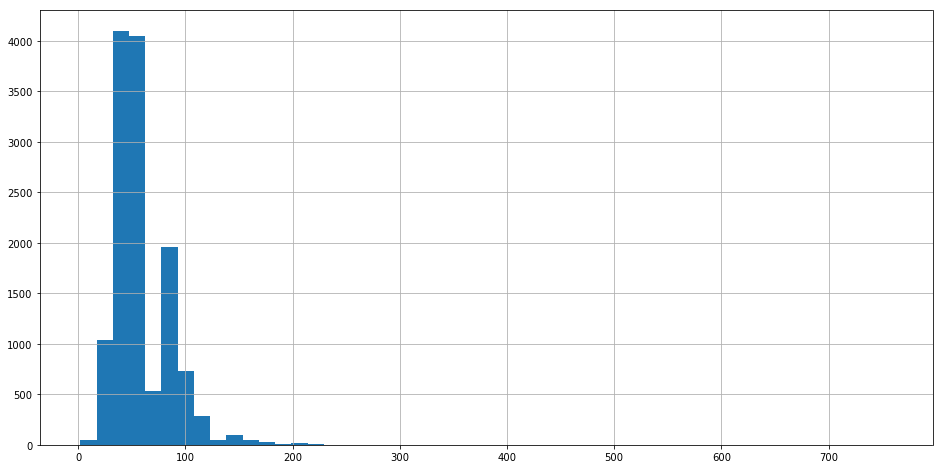

time: 278 ms


In [26]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

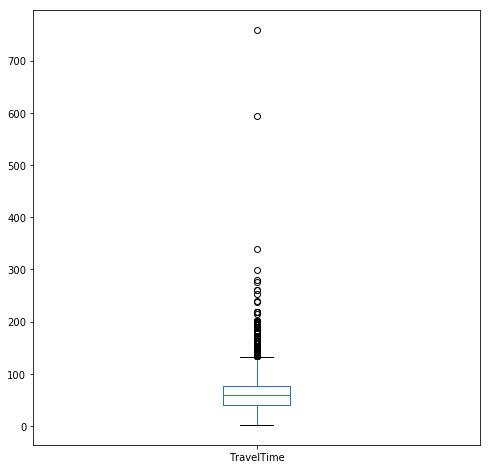

time: 219 ms


In [27]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [28]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    12986.000000
mean        59.226706
std         27.661573
min          2.000000
25%         40.000000
50%         59.000000
75%         77.000000
max        759.000000
Name: TravelTime, dtype: float64

time: 7 ms


Observation:  So the median and average are both around 59 seconds for this segment.  There are implausible extremes at both ends.

## Dropping outliers

In [29]:
# loading table of times to traverse segments at 80kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == 9090786, 'min_sec'].iloc[0]
print(lb)

14.5378563877
time: 11 ms


In [30]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond a conservative 2 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (2*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 131 outliers dropped.
time: 18 ms


In [31]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,Day,HourFrame
0,150,0.000000,9.5,55,132,0,0,Thursday,8
1,149,0.000000,27.0,71,3924,0,0,Tuesday,15
2,149,0.000000,4.0,63,5413,0,1,Saturday,23
3,148,0.000000,10.5,63,5413,0,0,Friday,17
4,148,0.000000,9.5,35,108,0,0,Thursday,8
5,145,0.000000,4.5,71,3924,0,0,Thursday,11
6,145,0.199951,11.5,63,5413,0,0,Tuesday,10
7,145,0.000000,2.5,38,135,1,0,Wednesday,14
8,145,0.000000,7.0,38,135,1,0,Tuesday,8
9,144,1.533203,4.5,64,1916,0,0,Monday,9


time: 72 ms


In [32]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage error scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    12855.000000
mean        58.150292
std         23.791611
min         15.000000
25%         40.000000
50%         59.000000
75%         76.000000
max        150.000000
Name: TravelTime, dtype: float64

time: 15 ms


Observation:  The mean drops by one second after removing outliers.

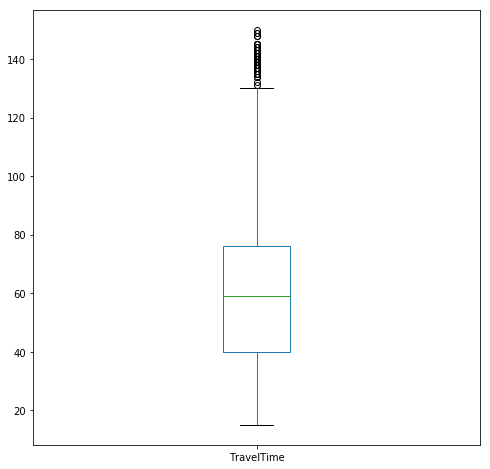

time: 220 ms


In [33]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## Visualising the data

### 1a Bar plot for mean TravelTime per HourFrame

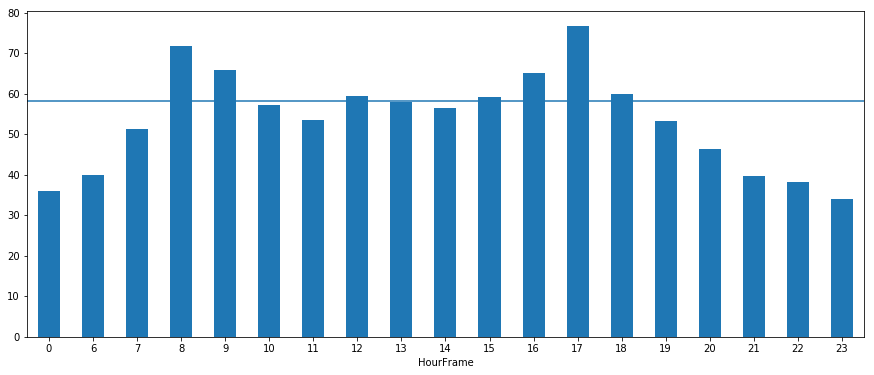

time: 241 ms


In [34]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 1b Bar plot for median TravelTime per HourFrame

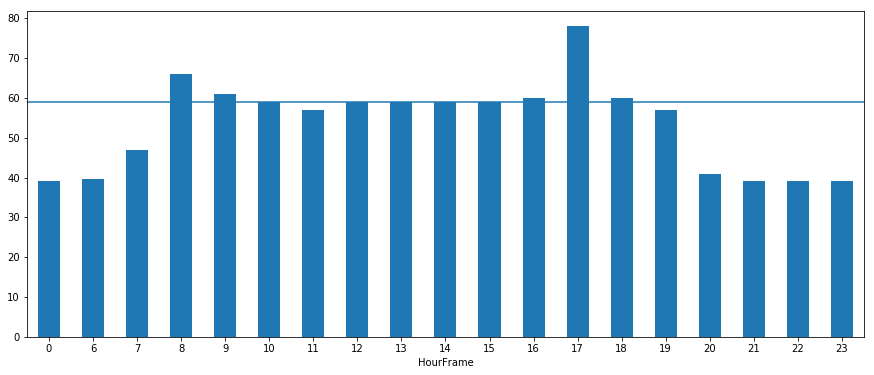

time: 237 ms


In [35]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  Busy at rush-hour, especially the evening.  At or above median most of the day, drops off after 7pm and up until 7am.

### 2a Bar plot for mean TravelTime per Day

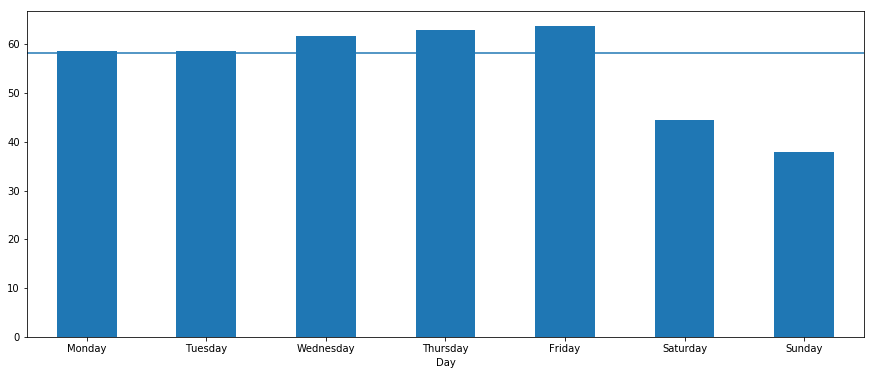

time: 157 ms


In [36]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2b Bar plot for median TravelTime per HourFrame

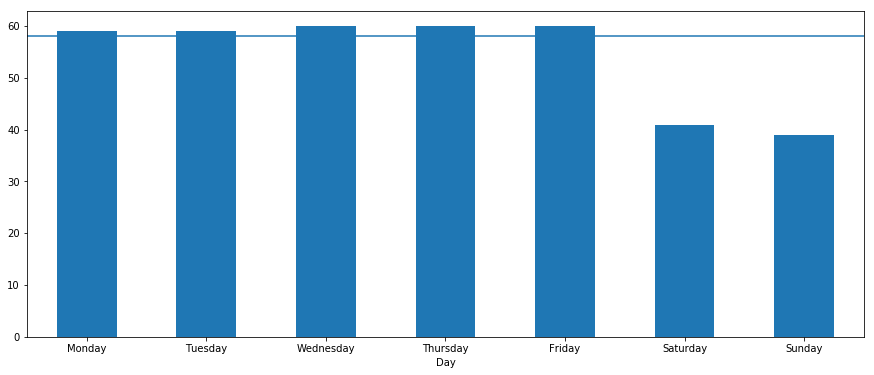

time: 147 ms


In [37]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  Weekdays at median or above, slight increase as the week goes on.  A good third or so quieter on weekends, more pronounced on Sunday.

### 3a Bar plot for mean TravelTime when SchoolHoliday true/false

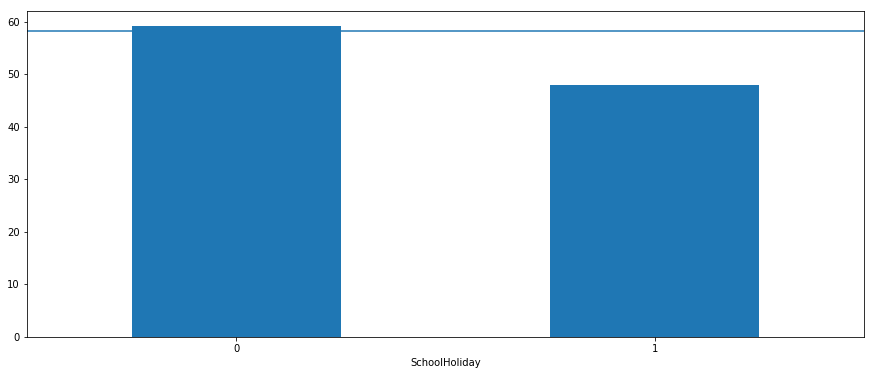

time: 133 ms


In [38]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 3b Bar plot for median TravelTime when SchoolHoliday true/false

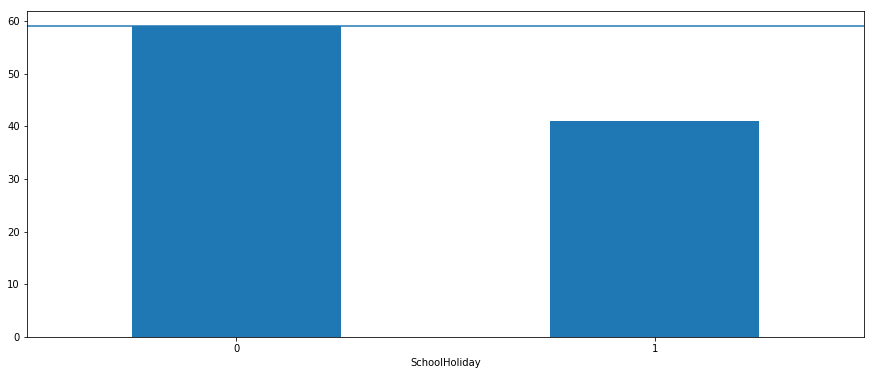

time: 186 ms


In [39]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

## Model training (statsmodels)

### 1a. Linear Regression model (via statsmodels - to see p-values)

Splitting data into 70% for training and 30% for testing

In [40]:
# Code to split data taken from here: http://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas

ssid_train=ssid_df.sample(frac=0.7, random_state=38)
ssid_test=ssid_df.drop(ssid_train.index)
print ("Training set size is",len(ssid_train))
print ("Training set size is",len(ssid_test))

Training set size is 8998
Training set size is 3857
time: 7 ms


In [41]:
lrle = sm.ols(formula="TravelTime ~ SchoolHoliday + WindSpeed + Rain + JPID_length + JPID_Freq + XBuses + C(HourFrame) + C(Day)", data=ssid_train).fit()

time: 4.81 s


In [42]:
print(lrle.summary())

                            OLS Regression Results                            
Dep. Variable:             TravelTime   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     134.3
Date:                Fri, 25 Aug 2017   Prob (F-statistic):               0.00
Time:                        04:43:56   Log-Likelihood:                -39626.
No. Observations:                8998   AIC:                         7.931e+04
Df Residuals:                    8967   BIC:                         7.953e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              48.9476    

In [43]:
# repeat on test frame and return Adj. R-squared value

#rsqa = stm.regression.linear_model.RegressionResults.rsquared_adj(lrle.predict(ssid_lin_test))
#print ("The predicted adjusted R-squared value on the test frame is", rsqa)

time: 1e+03 µs


### 1b. Repeat Linear Regression model via statsmodels with continuous features normalised

We need to normalise the relevant parts of the original data and then repeat the test/train split

In [44]:
# Normalising continuous features

ssid_lin = ssid_df
ssid_lin['WindSpeed'] = (ssid_lin['WindSpeed']-ssid_lin['WindSpeed'].min())/(ssid_lin['WindSpeed'].max()-ssid_lin['WindSpeed'].min())
ssid_lin['Rain'] = (ssid_lin['Rain']-ssid_lin['Rain'].min())/(ssid_lin['Rain'].max()-ssid_lin['Rain'].min())
ssid_lin['JPID_length'] = (ssid_lin['JPID_length']-ssid_lin['JPID_length'].min())/(ssid_lin['JPID_length'].max()-ssid_lin['JPID_length'].min())
ssid_lin['JPID_Freq'] = (ssid_lin['JPID_Freq']-ssid_lin['JPID_Freq'].min())/(ssid_lin['JPID_Freq'].max()-ssid_lin['JPID_Freq'].min())
ssid_lin

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,Day,HourFrame
0,150,0.000000,0.288136,0.692308,0.023845,0,0,Thursday,8
1,149,0.000000,0.881356,1.000000,0.724769,0,0,Tuesday,15
2,149,0.000000,0.101695,0.846154,1.000000,0,1,Saturday,23
3,148,0.000000,0.322034,0.846154,1.000000,0,0,Friday,17
4,148,0.000000,0.288136,0.307692,0.019409,0,0,Thursday,8
5,145,0.000000,0.118644,1.000000,0.724769,0,0,Thursday,11
6,145,0.043787,0.355932,0.846154,1.000000,0,0,Tuesday,10
7,145,0.000000,0.050847,0.365385,0.024399,1,0,Wednesday,14
8,145,0.000000,0.203390,0.365385,0.024399,1,0,Tuesday,8
9,144,0.335757,0.118644,0.865385,0.353604,0,0,Monday,9


time: 36 ms


In [45]:
ssid_lin_train=ssid_lin.sample(frac=0.7, random_state=38)
ssid_lin_test=ssid_lin.drop(ssid_lin_train.index)
print ("Training set size is",len(ssid_lin_train))
print ("Training set size is",len(ssid_lin_test))

Training set size is 8998
Training set size is 3857
time: 6 ms


In [46]:
lrle1 = sm.ols(formula="TravelTime ~ SchoolHoliday + WindSpeed + Rain + JPID_length + JPID_Freq + XBuses + C(HourFrame) + C(Day)", data=ssid_lin_train).fit()

time: 4.36 s


In [47]:
print(lrle1.summary())

                            OLS Regression Results                            
Dep. Variable:             TravelTime   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     134.3
Date:                Fri, 25 Aug 2017   Prob (F-statistic):               0.00
Time:                        04:44:00   Log-Likelihood:                -39626.
No. Observations:                8998   AIC:                         7.931e+04
Df Residuals:                    8967   BIC:                         7.953e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              47.6354    

In [48]:
# repeat on test frame and return Adj. R-squared value

# rsqa = stm.regression.linear_model.RegressionResults.rsquared_adj(lrle.predict(ssid_lin_test))
# print ("The predicted adjusted R-squared value on the test frame is", rsqa)

Error in callback <bound method LineWatcher.stop of <autotime.LineWatcher object at 0x0000000008152F98>> (for post_run_cell):


AssertionError: 

## Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### Prepare data for modelling via Scikit-learn

In [49]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,HF_6,HF_7,HF_8,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,150,0.000000,0.288136,0.692308,0.023845,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,149,0.000000,0.881356,1.000000,0.724769,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,149,0.000000,0.101695,0.846154,1.000000,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,148,0.000000,0.322034,0.846154,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,148,0.000000,0.288136,0.307692,0.019409,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,145,0.000000,0.118644,1.000000,0.724769,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,145,0.043787,0.355932,0.846154,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,145,0.000000,0.050847,0.365385,0.024399,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,145,0.000000,0.203390,0.365385,0.024399,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9,144,0.335757,0.118644,0.865385,0.353604,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


time: 116 ms


In [50]:
# remove any constant features

selector = VarianceThreshold()
selector.fit_transform(ssid_df)

array([[  1.50000000e+02,   0.00000000e+00,   2.88135593e-01, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.49000000e+02,   0.00000000e+00,   8.81355932e-01, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.49000000e+02,   0.00000000e+00,   1.01694915e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.50000000e+01,   0.00000000e+00,   2.20338983e-01, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.50000000e+01,   0.00000000e+00,   2.20338983e-01, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.50000000e+01,   0.00000000e+00,   4.06779661e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

time: 11 ms


In [51]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'JPID_Freq', 'XBuses', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 1e+03 µs


In [52]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 14 ms


In [53]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 19 ms


### 1a Linear Regression model (via scikit-learn) - training - default parameters

In [54]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 874 ms


In [55]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.301344262208
time: 22 ms


In [56]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 15.1902887061
The mean absolute percentage error is 26.1224634615
time: 3 ms


In [57]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 12.3671051709
The median absolute percentage error is 20.9611952049
time: 2 ms


### 1b Linear Regression model (via scikit-learn) - testing - default parameters

In [58]:
lr_preda = lr.predict(X_test)
lr_rsq = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.305518225466
time: 65 ms


In [59]:
lr_mae = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 15.2940481372
The mean absolute percentage error is 26.3008966698
time: 2 ms


In [60]:
lr_mdae = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 12.2303188916
The median absolute percentage error is 20.7293540536
time: 67 ms


### 2.1a Support Vector Machine Regression with Linear Kernel model - training - default parameters

In [61]:
svr_lin = SVR(kernel='linear')
svr_lin.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 5.03 s


In [62]:
svr_lin_pred = svr_lin.predict(X_train)
svr_lin_rsq = metrics.r2_score(y_train, svr_lin_pred)
print ("The R-squared value of the SVR with Linear Kernel model is", svr_lin_rsq)

The R-squared value of the SVR with Linear Kernel model is 0.250962179578
time: 2.22 s


In [63]:
svr_lin_mae = metrics.mean_absolute_error(y_train, svr_lin_pred)
print ("The mean absolute error of the SVR with Linear Kernel model is", svr_lin_mae)
print ("The mean absolute percentage error is", (((svr_lin_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Linear Kernel model is 14.7867524183
The mean absolute percentage error is 25.4285094401
time: 4 ms


In [64]:
svr_lin_mdae = metrics.median_absolute_error(y_train, svr_lin_pred)
print ("The median absolute error of the SVR with Linear Kernel model is", svr_lin_mdae)
print ("The median absolute percentage error is", (((svr_lin_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Linear Kernel model is 16.1731841802
The median absolute percentage error is 27.4121765766
time: 6 ms


### 2.1b Support Vector Machine Regression with Linear Kernel model - testing - default parameters

In [65]:
svr_lin_preda = svr_lin.predict(X_test)
svr_lin_rsq = metrics.r2_score(y_test, svr_lin_preda)
print ("The R-squared value of the SVR with Linear Kernel model is", svr_lin_rsq)

The R-squared value of the SVR with Linear Kernel model is 0.253450152839
time: 945 ms


In [66]:
svr_lin_mae = metrics.mean_absolute_error(y_test, svr_lin_preda)
print ("The mean absolute error of the SVR with Linear Kernel model is", svr_lin_mae)
print ("The mean absolute percentage error is", (((svr_lin_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Linear Kernel model is 15.0101931408
The mean absolute percentage error is 25.8127563904
time: 2 ms


In [67]:
svr_lin_mdae = metrics.median_absolute_error(y_test, svr_lin_preda)
print ("The median absolute error of the SVR with Linear Kernel model is", svr_lin_mdae)
print ("The median absolute percentage error is", (((svr_lin_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Linear Kernel model is 16.4780676485
The median absolute percentage error is 27.9289282179
time: 6 ms


### 2.1c Repeat SVR with Linear Kernel model, continuous data normalised - training  - default parameters

First we have to normalise the relevant data

In [68]:
# Normalising continuous features

ssid_norm = ssid_df
ssid_norm['WindSpeed'] = (ssid_norm['WindSpeed']-ssid_norm['WindSpeed'].min())/(ssid_norm['WindSpeed'].max()-ssid_norm['WindSpeed'].min())
ssid_norm['Rain'] = (ssid_norm['Rain']-ssid_norm['Rain'].min())/(ssid_norm['Rain'].max()-ssid_norm['Rain'].min())
ssid_norm['JPID_length'] = (ssid_norm['JPID_length']-ssid_norm['JPID_length'].min())/(ssid_norm['JPID_length'].max()-ssid_norm['JPID_length'].min())
ssid_norm['JPID_Freq'] = (ssid_norm['JPID_Freq']-ssid_norm['JPID_Freq'].min())/(ssid_norm['JPID_Freq'].max()-ssid_norm['JPID_Freq'].min())
ssid_norm

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,HF_6,HF_7,HF_8,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,150,0.000000,0.288136,0.692308,0.023845,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,149,0.000000,0.881356,1.000000,0.724769,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,149,0.000000,0.101695,0.846154,1.000000,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,148,0.000000,0.322034,0.846154,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,148,0.000000,0.288136,0.307692,0.019409,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,145,0.000000,0.118644,1.000000,0.724769,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,145,0.043787,0.355932,0.846154,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,145,0.000000,0.050847,0.365385,0.024399,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,145,0.000000,0.203390,0.365385,0.024399,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9,144,0.335757,0.118644,0.865385,0.353604,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


time: 56 ms


In [69]:
# prepare a list containing all remaining features bar the target

pred_features = list(ssid_norm)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'JPID_Freq', 'XBuses', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 3 ms


In [70]:
# prepare farget/predictive feature variables for use in scikit-learn modelling

X_norm = ssid_norm[pred_features]
y_norm = ssid_norm['TravelTime']

time: 7 ms


In [71]:
# split the data into training portion (70%) and final testing potion (30%)

Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_norm, y_norm, test_size = 0.3, random_state = 38)

time: 4 ms


Now onto modelling

In [72]:
svrn_lin = SVR(kernel='linear')
svrn_lin.fit(Xn_train, yn_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 3.91 s


In [73]:
svrn_lin_pred = svrn_lin.predict(X_train)
svrn_lin_rsq = metrics.r2_score(yn_train, svrn_lin_pred)
print ("The R-squared value of the SVR with Linear Kernel model is", svrn_lin_rsq)

The R-squared value of the SVR with Linear Kernel model is 0.250962179578
time: 2.19 s


In [74]:
svrn_lin_mae = metrics.mean_absolute_error(y_train, svr_lin_pred)
print ("The mean absolute error of the SVR with Linear Kernel model is", svrn_lin_mae)
print ("The mean absolute percentage error is", (((svrn_lin_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Linear Kernel model is 14.7867524183
The mean absolute percentage error is 25.4285094401
time: 4 ms


In [75]:
svrn_lin_mdae = metrics.median_absolute_error(y_train, svr_lin_pred)
print ("The median absolute error of the SVR with Linear Kernel model is", svrn_lin_mdae)
print ("The median absolute percentage error is", (((svrn_lin_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Linear Kernel model is 16.1731841802
The median absolute percentage error is 27.4121765766
time: 6 ms


### 2.1d Repeat SVR with Linear Kernel model, continuous data normalised - testing  - default parameters

In [76]:
svrn_lin_preda = svrn_lin.predict(Xn_test)
svrn_lin_rsq = metrics.r2_score(yn_test, svrn_lin_preda)
print ("The R-squared value of the SVR with Linear Kernel model is", svr_lin_rsq)

The R-squared value of the SVR with Linear Kernel model is 0.253450152839
time: 950 ms


In [77]:
svrn_lin_mae = metrics.mean_absolute_error(yn_test, svrn_lin_preda)
print ("The mean absolute error of the SVR with Linear Kernel model is", svr_lin_mae)
print ("The mean absolute percentage error is", (((svrn_lin_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Linear Kernel model is 15.0101931408
The mean absolute percentage error is 25.8127563904
time: 4 ms


In [78]:
svrn_lin_mdae = metrics.median_absolute_error(yn_test, svrn_lin_preda)
print ("The median absolute error of the SVR with Linear Kernel model is", svr_lin_mdae)
print ("The median absolute percentage error is", (((svrn_lin_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Linear Kernel model is 16.4780676485
The median absolute percentage error is 27.9289282179
time: 4 ms


### 2.2a Support Vector Machine Regression with Polynomial Kernel model - training - default parameters

In [79]:
svr_poly = SVR(kernel='poly')
svr_poly.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 4.04 s


In [80]:
svr_poly_pred = svr_poly.predict(X_train)
svr_poly_rsq = metrics.r2_score(y_train, svr_poly_pred)
print ("The R-squared value of the SVR with Polynomial Kernel model is", svr_poly_rsq)

The R-squared value of the SVR with Polynomial Kernel model is 0.00374110510042
time: 2.52 s


In [81]:
svr_poly_mae = metrics.mean_absolute_error(y_train, svr_poly_pred)
print ("The mean absolute error of the SVR with Polynomial Kernel model is", svr_poly_mae)
print ("The mean absolute percentage error is", (((svr_poly_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Polynomial Kernel model is 17.8357672447
The mean absolute percentage error is 30.6718448327
time: 5 ms


In [82]:
svr_poly_mdae = metrics.median_absolute_error(y_train, svr_poly_pred)
print ("The median absolute error of the SVR with Polynomial Kernel model is", svr_poly_mdae)
print ("The median absolute percentage error is", (((svr_poly_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Polynomial Kernel model is 18.1249603692
The median absolute percentage error is 30.7202718121
time: 3 ms


### 2.2b Support Vector Machine Regression with Polynomial Kernel model - testing - default parameters

In [83]:
svr_poly_preda = svr_poly.predict(X_test)
svr_poly_rsq = metrics.r2_score(y_test, svr_poly_preda)
print ("The R-squared value of the SVR with Polynomial Kernel model is", svr_poly_rsq)

The R-squared value of the SVR with Polynomial Kernel model is 0.00402948892811
time: 1.06 s


In [84]:
svr_poly_mae = metrics.mean_absolute_error(y_test, svr_poly_preda)
print ("The mean absolute error of the SVR with Polynomial Kernel model is", svr_poly_mae)
print ("The mean absolute percentage error is", (((svr_poly_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Polynomial Kernel model is 18.2119274927
The mean absolute percentage error is 31.318720776
time: 5 ms


In [85]:
svr_poly_mdae = metrics.median_absolute_error(y_test, svr_poly_preda)
print ("The median absolute error of the SVR with Polynomial Kernel model is", svr_poly_mdae)
print ("The median absolute percentage error is", (((svr_poly_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Polynomial Kernel model is 18.8607801005
The median absolute percentage error is 31.9674238992
time: 5 ms


### 2.2c Repeat SVR with Polynomial Kernel model, continuous data normalised - training - default parameters

In [86]:
svrn_poly = SVR(kernel='poly')
svrn_poly.fit(Xn_train, yn_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 4.04 s


In [87]:
svrn_poly_pred = svrn_poly.predict(Xn_train)
svrn_poly_rsq = metrics.r2_score(yn_train, svrn_poly_pred)
print ("The R-squared value of the SVR with Polynomial Kernel model is", svrn_poly_rsq)

The R-squared value of the SVR with Polynomial Kernel model is 0.00374110510042
time: 2.37 s


In [88]:
svrn_poly_mae = metrics.mean_absolute_error(yn_train, svrn_poly_pred)
print ("The mean absolute error of the SVR with Polynomial Kernel model is", svrn_poly_mae)
print ("The mean absolute percentage error is", (((svrn_poly_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Polynomial Kernel model is 17.8357672447
The mean absolute percentage error is 30.6718448327
time: 3 ms


In [89]:
svrn_poly_mdae = metrics.median_absolute_error(yn_train, svrn_poly_pred)
print ("The median absolute error of the SVR with Polynomial Kernel model is", svrn_poly_mdae)
print ("The median absolute percentage error is", (((svrn_poly_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Polynomial Kernel model is 18.1249603692
The median absolute percentage error is 30.7202718121
time: 7 ms


### 2.2d Repeat SVR with Polynomial Kernel model, continuous data normalised - testing  - default parameters

In [90]:
svrn_poly_preda = svrn_poly.predict(Xn_test)
svrn_poly_rsq = metrics.r2_score(yn_test, svrn_poly_preda)
print ("The R-squared value of the SVR with Polynomial Kernel model is", svrn_poly_rsq)

The R-squared value of the SVR with Polynomial Kernel model is 0.00402948892811
time: 1.01 s


In [91]:
svrn_poly_mae = metrics.mean_absolute_error(yn_test, svrn_poly_preda)
print ("The mean absolute error of the SVR with Polynomial Kernel model is", svrn_poly_mae)
print ("The mean absolute percentage error is", (((svrn_poly_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Polynomial Kernel model is 18.2119274927
The mean absolute percentage error is 31.318720776
time: 3 ms


In [92]:
svrn_poly_mdae = metrics.median_absolute_error(yn_test, svrn_poly_preda)
print ("The median absolute error of the SVR with Polynomial Kernel model is", svrn_poly_mdae)
print ("The median absolute percentage error is", (((svrn_poly_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Polynomial Kernel model is 18.8607801005
The median absolute percentage error is 31.9674238992
time: 3 ms


### 2.3a Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [93]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 5.06 s


In [94]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.209469066062
time: 3.49 s


In [95]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 15.4765608872
The mean absolute percentage error is 26.6147605294
time: 4 ms


In [96]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 13.3204700745
The median absolute percentage error is 22.5770679229
time: 27 ms


### 2.3b Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [97]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsq = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.203712885336
time: 1.51 s


In [98]:
svr_rbf_mae = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 15.837936681
The mean absolute percentage error is 27.2362119155
time: 3 ms


In [99]:
svr_rbf_mdae = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 14.090373174
The median absolute percentage error is 23.8819884306
time: 4 ms


### 2.3c Repeat SVR with RBF Kernel model, continuous data normalised - training  - default parameters

In [100]:
svrn_rbf = SVR(kernel='rbf')
svrn_rbf.fit(Xn_train, yn_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 5.01 s


In [101]:
svrn_rbf_pred = svrn_rbf.predict(Xn_train)
svrn_rbf_rsq = metrics.r2_score(yn_train, svrn_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svrn_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.209469066062
time: 3.37 s


In [102]:
svrn_rbf_mae = metrics.mean_absolute_error(yn_train, svrn_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svrn_rbf_mae)
print ("The mean absolute percentage error is", (((svrn_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 15.4765608872
The mean absolute percentage error is 26.6147605294
time: 2 ms


In [103]:
svrn_rbf_mdae = metrics.median_absolute_error(yn_train, svrn_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svrn_rbf_mdae)
print ("The median absolute percentage error is", (((svrn_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 13.3204700745
The median absolute percentage error is 22.5770679229
time: 5 ms


### 2.3d Repeat SVR with RBF Kernel model, continuous data normalised - testing  - default parameters

In [104]:
svrn_rbf_preda = svrn_rbf.predict(Xn_test)
svrn_rbf_rsq = metrics.r2_score(yn_test, svrn_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svrn_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.203712885336
time: 1.44 s


In [105]:
svrn_rbf_mae = metrics.mean_absolute_error(yn_test, svrn_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svrn_rbf_mae)
print ("The mean absolute percentage error is", (((svrn_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 15.837936681
The mean absolute percentage error is 27.2362119155
time: 4 ms


In [106]:
svrn_rbf_mdae = metrics.median_absolute_error(yn_test, svrn_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svrn_rbf_mdae)
print ("The median absolute percentage error is", (((svrn_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 14.090373174
The median absolute percentage error is 23.8819884306
time: 4 ms


### 3a Decision Tree Regression model - training - default parameters

In [107]:
# code from here: https://gist.github.com/JustGlowing/fa2c0ac39415eb271db6

dtr = DTR()
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

time: 40 ms


#### Printing ranking of features by estimated predictive value for Decision Tree Regression

In [108]:
# code adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
indices = np.argsort(dtr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", dtr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.182222709877
Day_Sunday 	 0.0946699643717
HF_17 	 0.0769722699673
JPID_Freq 	 0.0747004255173
Day_Saturday 	 0.0704935572094
JPID_length 	 0.0697149647036
HF_8 	 0.0636668355452
HF_23 	 0.043764307563
Rain 	 0.0359547962202
HF_21 	 0.0343775403375
SchoolHoliday 	 0.0321155008574
HF_22 	 0.0284401181624
HF_20 	 0.0243298111424
Day_Wednesday 	 0.0206348453931
Day_Thursday 	 0.017416776901
Day_Tuesday 	 0.0159268730103
HF_6 	 0.0158705919108
HF_16 	 0.0145455431868
HF_9 	 0.0144033318533
Day_Monday 	 0.0133568516474
HF_19 	 0.00757461855885
HF_7 	 0.00756534380689
HF_13 	 0.00616380489949
XBuses 	 0.00608392488368
HF_11 	 0.00541789788956
HF_18 	 0.00520009923252
HF_12 	 0.00502390101095
HF_14 	 0.00464811850216
HF_10 	 0.00456253690439
HF_15 	 0.0041821389347
time: 10 ms


In [109]:
dtr_pred = dtr.predict(X_train)
dtr_rsq = metrics.r2_score(y_train, dtr_pred)
print ("The R-squared value of the Decision Tree Regression model is", dtr_rsq)

The R-squared value of the Decision Tree Regression model is 0.604262866621
time: 9 ms


In [110]:
dtr_mae = metrics.mean_absolute_error(y_train, dtr_pred)
print ("The mean absolute error of the Decision Tree Regression model is", dtr_mae)
print ("The mean absolute percentage error is", (((dtr_mae)/ssid_df_mean)*100))

The mean absolute error of the Decision Tree Regression model is 10.5200140904
The mean absolute percentage error is 18.0910770696
time: 4 ms


In [111]:
dtr_mdae = metrics.median_absolute_error(y_train, dtr_pred)
print ("The median absolute error of the Decision Tree Regression model is", dtr_mdae)
print ("The median absolute percentage error is", (((dtr_mdae)/ssid_df_median)*100))

The median absolute error of the Decision Tree Regression model is 8.33333333333
The median absolute percentage error is 14.1242937853
time: 5 ms


### 3b Decision Tree Regression model - testing - default parameters

In [112]:
dtr_preda = dtr.predict(X_test)
dtr_rsq = metrics.r2_score(y_test, dtr_preda)
print ("The R-squared value of the Decision Tree Regression model is", dtr_rsq)

The R-squared value of the Decision Tree Regression model is 0.058705482822
time: 5 ms


In [113]:
dtr_mae = metrics.mean_absolute_error(y_test, dtr_preda)
print ("The mean absolute error of the Decision Tree Regression model is", dtr_mae)
print ("The mean absolute percentage error is", (((dtr_mae)/ssid_df_mean)*100))

The mean absolute error of the Decision Tree Regression model is 17.8079558315
The mean absolute percentage error is 30.6240180508
time: 4 ms


In [114]:
dtr_mdae = metrics.median_absolute_error(y_test, dtr_preda)
print ("The median absolute error of the Decision Tree Regression model is", dtr_mdae)
print ("The median absolute percentage error is", (((dtr_mdae)/ssid_df_median)*100))

The median absolute error of the Decision Tree Regression model is 15.1428571429
The median absolute percentage error is 25.6658595642
time: 4 ms


### 4a Decision Tree Regression with AdaBoost model - training - default parameters

In [115]:
abr = ABR()
abr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

time: 96 ms


In [116]:
indices = np.argsort(abr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", dtr.feature_importances_[indices[f]])

Ordered feature ranking:
Day_Sunday 	 0.0946699643717
HF_17 	 0.0769722699673
Day_Saturday 	 0.0704935572094
HF_23 	 0.043764307563
HF_8 	 0.0636668355452
HF_21 	 0.0343775403375
JPID_length 	 0.0697149647036
HF_22 	 0.0284401181624
HF_20 	 0.0243298111424
HF_16 	 0.0145455431868
SchoolHoliday 	 0.0321155008574
WindSpeed 	 0.182222709877
Rain 	 0.0359547962202
HF_7 	 0.00756534380689
HF_12 	 0.00502390101095
Day_Wednesday 	 0.0206348453931
HF_13 	 0.00616380489949
JPID_Freq 	 0.0747004255173
Day_Tuesday 	 0.0159268730103
HF_11 	 0.00541789788956
HF_10 	 0.00456253690439
HF_9 	 0.0144033318533
HF_15 	 0.0041821389347
HF_18 	 0.00520009923252
HF_6 	 0.0158705919108
HF_19 	 0.00757461855885
XBuses 	 0.00608392488368
Day_Monday 	 0.0133568516474
Day_Thursday 	 0.017416776901
HF_14 	 0.00464811850216
time: 22 ms


In [117]:
abr_pred = abr.predict(X_train)
abr_rsq = metrics.r2_score(y_train, abr_pred)
print ("The R-squared value of the Decision Tree Regression with AdaBoost model is", abr_rsq)

The R-squared value of the Decision Tree Regression with AdaBoost model is 0.168799372418
time: 9 ms


In [118]:
abr_mae = metrics.mean_absolute_error(y_train, abr_pred)
print ("The mean absolute error of the Decision Tree Regression with AdaBoost model is", abr_mae)
print ("The mean absolute percentage error is", (((abr_mae)/ssid_df_mean)*100))

The mean absolute error of the Decision Tree Regression with AdaBoost model is 16.9233850187
The mean absolute percentage error is 29.1028376977
time: 4 ms


In [119]:
abr_mdae = metrics.median_absolute_error(y_train, abr_pred)
print ("The median absolute error of the Decision Tree Regression with AdaBoost model is", abr_mdae)
print ("The median absolute percentage error is", (((abr_mdae)/ssid_df_median)*100))

The median absolute error of the Decision Tree Regression with AdaBoost model is 16.4711104848
The median absolute percentage error is 27.9171364149
time: 4 ms


### 4b Decision Tree Regression with AdaBoost model - testing - default parameters

In [120]:
abr_preda = abr.predict(X_test)
abr_rsq = metrics.r2_score(y_test, abr_preda)
print ("The R-squared value of the Decision Tree Regression with AdaBoost model is", abr_rsq)

The R-squared value of the Decision Tree Regression with AdaBoost model is 0.164259142034
time: 5 ms


In [121]:
abr_mae = metrics.mean_absolute_error(y_test, abr_preda)
print ("The mean absolute error of the Decision Tree Regression with AdaBoost model is", abr_mae)
print ("The mean absolute percentage error is", (((abr_mae)/ssid_df_mean)*100))

The mean absolute error of the Decision Tree Regression with AdaBoost model is 17.3281842221
The mean absolute percentage error is 29.7989635322
time: 3 ms


In [122]:
abr_mdae = metrics.median_absolute_error(y_test, abr_preda)
print ("The median absolute error of the Decision Tree Regression with AdaBoost model is", abr_mdae)
print ("The median absolute percentage error is", (((abr_mdae)/ssid_df_median)*100))

The median absolute error of the Decision Tree Regression with AdaBoost model is 16.4711104848
The median absolute percentage error is 27.9171364149
time: 3 ms


### 5a Gradient Boosting Regression model - training - default parameters

In [123]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 503 ms


In [124]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
Day_Sunday 	 0.0919315256354
Day_Saturday 	 0.081459994627
WindSpeed 	 0.0626385608979
HF_23 	 0.0625131869731
HF_21 	 0.0577906688831
HF_17 	 0.0571808805789
HF_22 	 0.0506883658403
HF_20 	 0.0480303314026
HF_6 	 0.0476049387155
JPID_length 	 0.0436203261345
SchoolHoliday 	 0.0432198852518
HF_8 	 0.036512515217
HF_7 	 0.0353189810503
Rain 	 0.0321940297976
Day_Monday 	 0.0303285201065
Day_Tuesday 	 0.0299078496954
HF_19 	 0.029307549929
HF_16 	 0.0283443953179
HF_9 	 0.0270620626713
JPID_Freq 	 0.0265663185551
HF_11 	 0.0211465509246
HF_12 	 0.0126923829868
HF_15 	 0.0100827126862
Day_Thursday 	 0.00762840189191
Day_Wednesday 	 0.00688544929554
XBuses 	 0.00669438314533
HF_10 	 0.0054748099833
HF_18 	 0.00476189433528
HF_14 	 0.00241252747089
HF_13 	 0.0
time: 100 ms


In [125]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.333130529472
time: 14 ms


In [126]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 14.6542515253
The mean absolute percentage error is 25.2006500622
time: 3 ms


In [127]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 12.0451166962
The median absolute percentage error is 20.4154520275
time: 2 ms


### 5b Gradient Boosting Regression model - - testing - default parameters

In [128]:
gbr_preda = gbr.predict(X_test)
gbr_rsq = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.322454794109
time: 9 ms


In [129]:
gbr_mae = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 15.0115111789
The mean absolute percentage error is 25.8150229966
time: 3 ms


In [130]:
gbr_mdae = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 12.4185289582
The median absolute percentage error is 21.0483541664
time: 10 ms


### 6a Random Forest Regression model (all default) - training - default parameters

In [131]:
rfr = RFR(n_jobs = cores)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

time: 115 ms


In [132]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", dtr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.182222709877
Day_Sunday 	 0.0946699643717
JPID_Freq 	 0.0747004255173
JPID_length 	 0.0697149647036
HF_17 	 0.0769722699673
Day_Saturday 	 0.0704935572094
HF_8 	 0.0636668355452
Rain 	 0.0359547962202
HF_23 	 0.043764307563
HF_21 	 0.0343775403375
SchoolHoliday 	 0.0321155008574
HF_22 	 0.0284401181624
Day_Wednesday 	 0.0206348453931
Day_Thursday 	 0.017416776901
Day_Tuesday 	 0.0159268730103
HF_20 	 0.0243298111424
HF_9 	 0.0144033318533
Day_Monday 	 0.0133568516474
HF_16 	 0.0145455431868
HF_6 	 0.0158705919108
XBuses 	 0.00608392488368
HF_10 	 0.00456253690439
HF_14 	 0.00464811850216
HF_7 	 0.00756534380689
HF_19 	 0.00757461855885
HF_12 	 0.00502390101095
HF_18 	 0.00520009923252
HF_15 	 0.0041821389347
HF_11 	 0.00541789788956
HF_13 	 0.00616380489949
time: 112 ms


In [133]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.572151689699
time: 106 ms


In [134]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 11.4808366155
The mean absolute percentage error is 19.7433861066
time: 4 ms


In [135]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 8.73178571429
The median absolute percentage error is 14.7996368039
time: 4 ms


### 6b Random Forest Regression model (all default) - testing - default parameters

In [136]:
rfr_preda = rfr.predict(X_test)
rfr_rsq = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.166267811515
time: 103 ms


In [137]:
rfr_mae = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 16.9478623504
The mean absolute percentage error is 29.1449309204
time: 4 ms


In [138]:
rfr_mdae = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 13.9333333333
The median absolute percentage error is 23.615819209
time: 3 ms


### Random Forest Regression model - OTT Gridsearch!

The data from this has been lost, but it took many hours to run.  Too many combinations of parameters chosen, as this method exhaustively models each and every one!  Decided RandomizedSearchCV would be more cost-effective approach better approach.

In [139]:
rfr = RFR()
params = { 
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth':[5, 8, 15, 25, 30, None],
    'min_samples_split':[1.0, 2, 5, 10, 15, 100],
    'min_samples_leaf':[1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfr = GSCV(estimator=rfr, param_grid=params, cv= 5)
CV_rfr.fit(X, y)

KeyboardInterrupt: 

time: 23min 17s


In [ ]:
print (CV_rfr.best_params_)

In [ ]:
CV_rfr.best_score_

In [ ]:
rfr_pred = CV_rfr.predict(X)
rfr_rsq = metrics.r2_score(y, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

In [ ]:
rfr_mae = metrics.mean_absolute_error(y, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)

In [ ]:
rfr_mdae = metrics.median_absolute_error(y, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)